In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [81]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam 


%matplotlib inline

In [82]:
# the training data
df_train = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv")
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [83]:
# to view the labels in each tag
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))


In [84]:
labels

['partly_cloudy',
 'road',
 'water',
 'clear',
 'blooming',
 'habitation',
 'cultivation',
 'selective_logging',
 'conventional_mine',
 'slash_burn',
 'artisinal_mine',
 'cloudy',
 'haze',
 'primary',
 'blow_down',
 'bare_ground',
 'agriculture']

In [85]:
# checking the sample submission file
df_test = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
df_test.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


### Lets have a look at the training images

In [86]:
# train image path definition
image_path = "../input/planets-dataset/planet/planet/train-jpg/"

ValueError: num must be 1 <= num <= 12, not 0

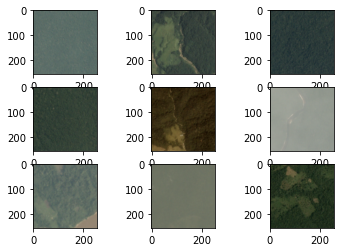

In [87]:
#having a look at the some of the images
for i in range(12):
    plt.subplot(330+ 1 + i)
    #filename definition
    filename  = image_path + "train" + "_"  + str(i)  + ".jpg"
    #load image
    img = imread(filename)
    plt.imshow(img)
plt.show()

### The test files, comparing the length of the two test files with the sample submission file

In [89]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission.shape[0] == float(test1[0])+float(test2[0])

(256, 256, 3)


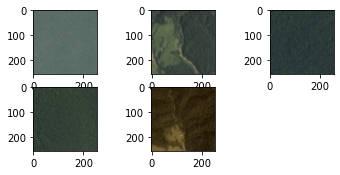

In [90]:
from skimage import io
for i in range(5):
    image = io.imread(image_path+'train_{}.jpg'.format(i))
    plt.subplot(330+ 1 + i)
    plt.imshow(image)
print(image.shape)

In [92]:
# vectorizing the labels in the df_train
for tag in labels:
    df_train[tag] = df_train['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
df_train['image_name'] = df_train['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
df_train.head()

,image_name,tags,partly_cloudy,road,water,clear,blooming,habitation,cultivation,selective_logging,conventional_mine,slash_burn,artisinal_mine,cloudy,haze,primary,blow_down,bare_ground,agriculture
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
2,train_2.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,train_3.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1


In [93]:
df_test['image_name'] = df_test['image_name'].apply(lambda x: '{}.jpg'.format(x))
df_test.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [94]:
%%time
y_col = list(df_train.columns[2:]) 

#instatiate  data generator object
datagen = ImageDataGenerator(rescale=1.0/255.0)

# load images from dataframe
X = datagen.flow_from_dataframe(dataframe=df_train,
                                directory=image_path,
                                x_col='image_name', y_col=y_col,
                                target_size=(128, 128), 
                                class_mode='raw', seed=1,
                                batch_size=128)


Found 40479 validated image filenames.
CPU times: user 843 ms, sys: 801 ms, total: 1.64 s
Wall time: 7.25 s


In [96]:
#using Fbeta consider the evaluation metric
#using a function

def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

### Multi-label accuracy detector

In [98]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue),tf.float32) * tf.cast(tf.logical_not(ypred),tf.float32),
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

#### creating base convnet
****

### Creating a model

In [99]:
def model():
    model = Sequential()
    #add convolution layer
    model.add(Conv2D(32,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform", input_shape =[64,64,3]))
    model.add(Conv2D(32,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))

    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    #add another convolutional layer 2
    model.add(Conv2D(64,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    model.add(Conv2D(64,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    
    
    #add another convolutional layer 3
    model.add(Conv2D(128,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    model.add(Conv2D(128,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    
    #add another convolutional layer 4
    model.add(Conv2D(256,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    model.add(Conv2D(256,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    

    #add a flattening layer
    model.add(Flatten())
    #add a fully connected layer
    model.add(Dense(128,activation ="relu",kernel_initializer="he_uniform"))
    model.add(Dense(17,activation ="sigmoid"))
    optimizer = Adam()
    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics =[fbeta])

    return model
    

In [100]:
checkpoint = ModelCheckpoint(filepath='best_model.hdf5',
                                        monitor='val_fbeta',                                        
                                        mode='max', save_best_only=True,
                                        save_weights_only=True)

### image genearator for the data

In [101]:
image_gen = ImageDataGenerator(rescale=1/255,validation_split=0.2,
                               shear_range= 0.2,zoom_range= 0.2,
                               horizontal_flip=True)

# generating the 80% training image data
train_ = image_gen.flow_from_dataframe(dataframe=df_train,
                                          directory=image_path,
                                          x_col='image_name', y_col=y_col,
                                          target_size=(64, 64),
                                          class_mode='raw', seed=0,
                                          batch_size=64, subset='training')

# generating the 20% validation image data
val_ = image_gen.flow_from_dataframe(dataframe=df_train,
                                        directory=image_path, x_col='image_name',
                                        y_col=y_col,target_size=(64, 64), 
                                        class_mode='raw', seed=0,
                                        batch_size=64, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


### Setting step size 

In [104]:
train_step_size = int(np.ceil(train_gen.samples / train_.batch_size))
val_step_size = int(np.ceil(val_.samples / train_.batch_size))
train_step_size,val_step_size

(506, 127)

### Setting up the models

> Model 1

In [105]:
model_1 = model() # building a sequential model for training

model_1.fit(x=train_,
           steps_per_epoch=train_step_size,
           validation_data=val_, 
           validation_steps=val_step_size,
           epochs=17, 
           callbacks=[checkpoint])

Epoch 1/17
506/506 [==============================] - 134s 265ms/step - loss: 0.2012 - fbeta: 0.7168 - val_loss: 0.1726 - val_fbeta: 0.7668
Epoch 2/17
506/506 [==============================] - 131s 259ms/step - loss: 0.1521 - fbeta: 0.8005 - val_loss: 0.1480 - val_fbeta: 0.8134
Epoch 3/17
506/506 [==============================] - 131s 260ms/step - loss: 0.1398 - fbeta: 0.8201 - val_loss: 0.1315 - val_fbeta: 0.8358
Epoch 4/17
506/506 [==============================] - 132s 260ms/step - loss: 0.1324 - fbeta: 0.8340 - val_loss: 0.1291 - val_fbeta: 0.8351
Epoch 5/17
506/506 [==============================] - 134s 264ms/step - loss: 0.1267 - fbeta: 0.8451 - val_loss: 0.1247 - val_fbeta: 0.8590
Epoch 6/17
506/506 [==============================] - 134s 264ms/step - loss: 0.1226 - fbeta: 0.8505 - val_loss: 0.1249 - val_fbeta: 0.8529
Epoch 7/17
506/506 [==============================] - 133s 264ms/step - loss: 0.1193 - fbeta: 0.8553 - val_loss: 0.1193 - val_fbeta: 0.8573
Epoch 8/17
506/506 [

>Model 2 for adding the weight

In [106]:
model_2 = model() # building a sequential model for testing

#loading in the weights of the trained model
model_2.load_weights('best_model.hdf5') 

In [107]:
test_path = '../input/planets-dataset/planet/planet/test-jpg'

In [109]:
# creating 2 test files , test_1, test_2
# for the main test file
test_1 = df_test.iloc[:40669]['image_name'].reset_index().drop('index',1)

# for the additional test file
test_2 = df_test.iloc[40669:]['image_name'].reset_index().drop('index',1)

In [111]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe

test_gen = ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_1_gen = test_gen.flow_from_dataframe(dataframe=test_1,
                                         directory=test_path, x_col='image_name',
                                         y_col=None,
                                         batch_size=64, shuffle=False,
                                         class_mode=None, target_size=(64, 64))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
test_1_step = int(np.ceil(test_1_gen.samples / test_1_gen.batch_size))

Found 40669 validated image filenames.


In [113]:
test_1_gen.reset() # reseting the generator to be sure of avoiding shuffling
pred_1 = model_2.predict(test_1_gen, 
                       steps=test_1_step, 
                       verbose=1) 

636/636 [==============================] - 144s 226ms/step


In [116]:
test_1_filenames = test_1_gen.filenames 
# converting the predictions of the first 40669 to tag names
pred_1_tags = pd.DataFrame(pred_1)
pred_1_tags = pred_1_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)

# creating a new dataframe to store the predictions and the actual tags
pred_1_df = pd.DataFrame({'image_name': test_1_filenames, 'tags': pred_1_tags})
pred_1_df.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [118]:
test_add = '../input/planets-dataset/test-jpg-additional/test-jpg-additional/'
test_2_gen = test_gen.flow_from_dataframe(dataframe=test_2,
                                                directory=test_add,
                                                x_col='image_name',
                                                y_col=None, 
                                                batch_size=64, shuffle=False, 
                                                class_mode=None, target_size=(64, 64))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
test_2_step = int(np.ceil(test_2_gen.samples / test_2_gen.batch_size))
test_2_step

Found 20522 validated image filenames.


321

In [ ]:
test_2_gen.reset() 
pred_2 = model_2.predict(test_2_gen, steps=test_2_step, verbose=1)
test_2_filenames = test_2_gen.filenames  

113/321 [=========>....................] - ETA: 46s

In [ ]:
# converting the predictions of the remaining images to tag names
pred_2_tags = pd.DataFrame(pred_2)
pred_2_tags = pred_2_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)

In [ ]:
# creating new dataframe
pred_2_df = pd.DataFrame({'image_name': test_2_filenames, 'tags': pred_2_tags})
pred_2_df.head()

In [ ]:
submission = pred_1_df.append(pred_2_df,ignore_index=True)
    
submission = submission.reset_index().drop('index', axis=1)
print(submission.shape)
submission.head()

In [ ]:
# removing the .jpg extension from 'iamge_name' column
submission['image_name'] = submission['image_name'].apply(lambda x: x[:-4])
submission.head()

In [ ]:
submission.to_csv('Summission.csv', index=False) # saving the predictions